In [1]:
from os import listdir
import csv
import os
import numpy as np
import pandas as pd
from scipy.misc import imresize, imread, imshow
import skimage
from skimage import io
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [278]:
def load_img(img_filename):
    """
    Load image from the filename. Default is to load in color if
    possible.
    Args:
        img_name (string): string of the image name, relative to
            the image directory.
    Returns:
        np array of float32: an image as a numpy array of float32
    """
    img = skimage.img_as_float(imread(
        img_filename,mode='RGB')).astype(np.float32)
    if img.ndim == 2:
        img = img[:, :, np.newaxis]
    elif img.shape[2] == 4:
        img = img[:, :, :3]
    
    '''Subtract channel vise mean'''
    ch_mean = np.load('preprocessing/ch_mean.npy')
    img = img - ch_mean
    return img

In [265]:
class DictIterator():
    '''
    Class for iterating over a pandas data frame with filenames and addresses

    TODO
    add comments
    '''
    def __init__(self,csv_location = None,
                 batch_size=32,
                 shuffle=False,
                 target_size=(64,64)):
        
        if csv_location is not None:
            self.df = pd.read_csv(csv_location)
        self.N = self.df.shape[0]
        print(self.N)
        self.batch_size = batch_size
        self.total_batches_seen = 0
        self.index_gen = self._idx_gen(self.N,batch_size,shuffle)
        self.target_size = target_size
        self.img_set = None
        
    def _idx_gen(self,N,batch_size=32,shuffle=False):
        batch_index = 0
        while 1:
            if batch_index == 0:
                index_array = np.arange(N)
                if shuffle:
                    index_array = np.random.permutation(N)
            current_index = (batch_index * batch_size) % N
            if N >= current_index + batch_size:
                current_batch_size = batch_size
                batch_index += 1
            else:
                current_batch_size = N - current_index
                batch_index = 0
            self.total_batches_seen += 1
            yield (index_array[current_index: current_index + current_batch_size],
                   current_index, current_batch_size)
            
    def batch_gen(self):
        while 1:
            index_array, current_index, current_batch_size = self.index_gen.__next__()
            img = [imresize(load_img(self.df.iloc[i]['filename']),size=self.target_size) for i in index_array]
            img = np.array(img)
            lab = [self.df.iloc[i].iloc[1:].values.astype('float32') for i in index_array]
            lab = np.array(lab)
            print(img.shape)
            print(lab.shape)
            plt.imshow(img[0])
            yield img,lab
    
    def channel_mean(self):
        self.img_set = np.array([load_img(self.df.iloc[i]['filename']) for i in range(self.N)])
        
        

In [266]:
d = DictIterator(csv_location='preprocessing/trainset.csv')
d.channel_mean()

100000


In [271]:
print(d.img_set.shape)
r = np.mean(d.img_set[:,:,:,0],  axis=0)
g = np.mean(d.img_set[:,:,:,1],  axis=0)
b = np.mean(d.img_set[:,:,:,2],  axis=0)



np.save('preprocessing/r.npy',r)
np.save('preprocessing/g.npy',g)
np.save('preprocessing/b.npy',b)



(100000, 64, 64, 3)


In [277]:
ch_mean = np.zeros((64,64,3))
print(ch_mean.shape)
ch_mean[:,:,0] = r
ch_mean[:,:,1] = g
ch_mean[:,:,2] = b
np.save('preprocessing/ch_mean.npy',ch_mean)

(64, 64, 3)


In [240]:
from model_defs import *
from utils import *
import argparse
import pandas as pd
import os
import numpy as np
import csv
from keras.models import model_from_json




            

In [249]:
def try_modelx(csv_location='preprocessing/valset.csv',batch_size=64,mid='m1'):


    #define the batch generator   (validation set)
    val_datagen = CSVGenerator(csv_location=csv_location,
                                 batch_size=batch_size)

    val_generator = val_datagen.batch_gen()

    x = tf.placeholder(tf.float32, shape=(None, 64, 64, 3))

    # load json and create model
    json_file = open('models/'+mid+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights("models/"+mid+".h5")
    print("Loaded model from disk")

    d = val_generator.__next__()
    pred = model(x)
    pred
    # evaluate loaded model on test data
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    #val_loss = model.evaluate_generator(
    #   generator = val_generator,
    #   val_samples = val_datagen.get_data_size())

    #print("%s: %.2f%%" % (model.metrics_names[1], val_loss[1]*100))
    #print(val_loss)

    pass

In [250]:
try_modelx()


10000
Loaded model from disk


In [252]:
import os
directory = '/dccstor/dlw/ambrish/examples/adversarial/models/m1'
if not os.path.exists(directory):
    os.makedirs(directory)

In [254]:
mid = 'm1'
epoch = 100
val_loss = [1.32,23.4]
with open('models/'+mid+'/acc_log.csv','a') as resultFile:
    r = np.concatenate([np.asarray([epoch]),val_loss])
    wr = csv.writer(resultFile,lineterminator='\n')
    
    wr.writerows([r])
    wr.writerow(['f','r','r'])

In [83]:
from os import listdir
import csv
import os
import numpy as np
import pandas as pd
from scipy.misc import imresize, imread, imshow
import skimage
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
import argparse
from pathlib import Path

class tinyImageNet(object):

    def __init__(self,fpath=None):
        self.fpath = fpath
        self.classes = None

    def make_train_csv(self):
        '''
        for tiny ImageNet folder structure (train)
        '''
        self.classes = listdir(os.path.join(self.fpath,'train'))
        num_classes = len(self.classes)
        traincsv_file = Path('trainset.csv')
        if traincsv_file.is_file():
            pass
        else:
            with open('trainset.csv', 'wt') as csvfile:
                csvwriter = csv.writer(csvfile, delimiter=',')
                csvwriter.writerow(['filename']+self.classes) #csv header
    
                c_idx = 0
                for class_ in self.classes:
                    class_path = os.path.join(self.fpath,'train',class_,'images')
                    images_ = listdir(class_path)
                    for image_ in images_:
    
                        file_path = os.path.join(class_path,image_)
    
                        label = np.zeros(num_classes)
                        label[c_idx] = 1
    
                        csvwriter.writerow([file_path] + list(map(str, label)))
                    c_idx+=1

    def make_val_csv(self):
        '''
        for tiny ImageNet folder structure (val)
        '''
        valcsv_file = Path('val.csv')
        if valcsv_file.is_file():
            pass
        else:
            with open(os.path.join(self.fpath,'val/val_annotations.txt'), 'rt') as csvfile:
                
                reader = csv.reader(csvfile, delimiter='\t')
                
                with open('valset.csv', 'wt') as csvfile:
                    
                    csvwriter = csv.writer(csvfile, delimiter=',')
                    csvwriter.writerow(['filename']+self.classes)
                    
                    for row in reader:

                        file_path = os.path.join(self.fpath,'val','images',row[0])
                        
                        label = np.zeros(len(self.classes))
                        label[self.classes.index(row[1])] = 1
                        
                        csvwriter.writerow([file_path] + list(map(str, label)))            
                
    def make_csvs(self):
        self.make_train_csv()
        self.make_val_csv()

In [119]:
import _pickle as cPickle
from scipy.misc import imsave
# Width and height of each image.
img_size = 32

# Number of channels in each image, 3 channels: Red, Green, Blue.
num_channels = 3

# Length of an image when flattened to a 1-dim array.
img_size_flat = img_size * img_size * num_channels

# Number of classes.
num_classes = 10

# Number of files for the training-set.
_num_files_train = 5

# Number of images for each batch-file in the training-set.
_images_per_file = 10000

# Total number of images in the training-set.
# This is used to pre-allocate arrays for efficiency.
_num_images_train = _num_files_train * _images_per_file

classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


def save_figs(dest_path=None, mode=None, cls=None, filenames=None, images=None):
    '''helper function to save images'''
    if mode=='train':
        for i in range(filenames.shape[0]):
            imsave(os.path.join(dest_path,mode,classes[cls[i]],filenames[i].decode('ascii')),images[i])
    else:
        for i in range(filenames.shape[0]):
            imsave(os.path.join(dest_path,mode,'images',filenames[i].decode('ascii')),images[i])
            with open(os.path.join(dest_path,mode,'annotations.csv'), 'a') as csvfile:
                csvwriter = csv.writer(csvfile, delimiter=',')
                csvwriter.writerow([filenames[i].decode('ascii'),classes[cls[i]]]) #csv header
            # save this in annotations classes[cls[i]]
        
        
    pass

def _convert_images(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images

def _unpickle(file):
    '''Unpickle the files (use bytes encoding for compatibility with Python3)'''
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo,encoding='bytes')
        return dict

class cifar10(object):
    '''
    Preprocessing the data set and making AdvFlow compatible csv files for CIFAR10
    Also, saves the JPEGs for the trianing and test set which facilitates
    easy visualisation of adversarial images
    '''
    
    
    def __init__(self,fpath=None):
        self.fpath = fpath
        if fpath is None:
            raise ValueError
        self.classes = 10
    
    def save_jpegs(self,source_path=None):
        
        ''' saves JPEGs structured into class wise sub folders'''
        
        dest_path = self.fpath
        if source_path is None:
            raise ValueError
            
        files = os.listdir(source_path)
        batches = ['data_batch_1','data_batch_2', 'data_batch_3','data_batch_4', 'data_batch_5', 'test_batch']
        
        #train_batches = batches[0:5]
        #test_batches = batches[5:6]
        
        from functools import reduce
        test = reduce(lambda x,y : x and y, [b in files for b in batches])
        if test is False:
            raise ValueError
            
        #make class dirs
        if not(os.path.exists(dest_path)):
            os.makedirs(dest_path)
        
        for c in classes:
            if not(os.path.exists(os.path.join(dest_path,'train',c))):
                os.makedirs(os.path.join(dest_path,'train',c))
        if not(os.path.exists(os.path.join(dest_path,'test','images'))):
            os.makedirs(os.path.join(dest_path,'test','images'))
        

        for b in batches:
            
            # Load the pickled data-file.
            data = _unpickle(source_path+'/'+b)
            
            print(data.keys())

            # Get the raw images.
            raw_images = data[b'data']
        
            # Get the class-numbers for each image. Convert to numpy-array.
            cls = np.array(data[b'labels'])

            #filenames
            filenames = np.array(data[b'filenames'])

            # Convert the images.
            images = _convert_images(raw_images)
            print(images.shape)
            
            # save images as jpegs
            if b == 'test_batch':
                save_figs(dest_path=dest_path, mode='test',cls=cls, filenames=filenames, images=images)
            else:
                save_figs(dest_path=dest_path, mode='train',cls=cls, filenames=filenames, images=images)
            

    def make_train_csv(self, traincsv=None):
        '''
        for cifar10_sets folder structure (train)
        '''
        self.classes = classes
        num_classes = len(self.classes)
        
        traincsv_file = Path(traincsv)
        if False:
            pass
        else:
            with open(traincsv, 'wt') as csvfile:
                csvwriter = csv.writer(csvfile, delimiter=',')
                csvwriter.writerow(['filename']+self.classes) #csv header
    
                c_idx = 0
                for class_ in self.classes:
                    class_path = os.path.join(self.fpath,'train',class_)
                    images_ = listdir(class_path)
                    for image_ in images_:
    
                        file_path = os.path.join(class_path,image_)
    
                        label = np.zeros(num_classes)
                        label[c_idx] = 1
    
                        csvwriter.writerow([file_path] + list(map(str, label)))
                    c_idx+=1

    def make_test_csv(self, valcsv=None):
        '''
        for tiny ImageNet folder structure (val)
        '''
        valcsv_file = Path(valcsv)
        if valcsv_file.is_file():
            pass
        else:
            with open(os.path.join(self.fpath,'test','annotations.csv'), 'rt') as csvfile:
                
                reader = csv.reader(csvfile, delimiter='\t')
                
                with open(valcsv, 'wt') as csvfile:
                    
                    csvwriter = csv.writer(csvfile, delimiter=',')
                    csvwriter.writerow(['filename']+self.classes)
                    
                    for row in reader:

                        file_path = os.path.join(self.fpath,'test','images',row[0])
                        
                        label = np.zeros(len(self.classes))
                        label[self.classes.index(row[1])] = 1
                        
                        csvwriter.writerow([file_path] + list(map(str, label)))            
                
    def make_csvs(self):
        self.make_train_csv(traincsv='/dccstor/dlw/ambrish/examples/adversarial/preprocessing/train_cifar10.csv')
        self.make_test_csv(valcsv='/dccstor/dlw/ambrish/examples/adversarial/preprocessing/test_cifar10.csv')

In [120]:
c = cifar10(fpath='/dccstor/dlw/ambrish/data/cifar10/cifar10-set/')
#c.save_jpegs(source_path='/dccstor/dlw/ambrish/data/cifar10/cifar-10-batches-py/')
c.make_csvs()

## Check the difference in numpy arrays uding different loads

In [1]:
from keras.datasets import cifar10
from keras.utils import np_utils, generic_utils
from scipy.misc import imresize, imread, imshow
import skimage
from skimage import io
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from utils import *

Using TensorFlow backend.


Raw loading
type: uint8
Sample
X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Y_train shape: (50000, 10)
Y_test shape: (10000, 10)


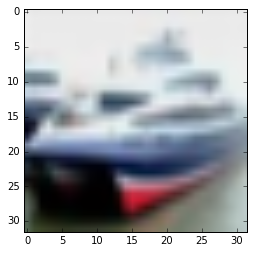

In [4]:
''' The one that works'''
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Raw loading')
print('type:', X_train.dtype)
print('Sample')


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

plt.imshow(X_test[1])

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print('Y_train shape:', Y_train.shape)
print('Y_test shape:', Y_test.shape)

### Conlusions
- The raw image has type unit8
- The images look humanly perecptible in both unit8 and float32 format

number of samples loaded 50000
number of samples loaded 10000
Raw loading
type: float32
Sample
[[[ 0.43529412  0.53725493  0.69803923]
  [ 0.44313726  0.54509807  0.69803923]
  [ 0.4509804   0.5529412   0.71372551]
  ..., 
  [ 0.58431375  0.66274512  0.81568629]
  [ 0.56078434  0.64313728  0.79215688]
  [ 0.54509807  0.627451    0.77254903]]

 [[ 0.43921569  0.5411765   0.7019608 ]
  [ 0.44705883  0.54901963  0.70588237]
  [ 0.4627451   0.56470591  0.72549021]
  ..., 
  [ 0.627451    0.69411767  0.81960785]
  [ 0.58039218  0.66666669  0.80392158]
  [ 0.5411765   0.627451    0.7764706 ]]

 [[ 0.44313726  0.54509807  0.7019608 ]
  [ 0.4509804   0.5529412   0.70980394]
  [ 0.4627451   0.56470591  0.72549021]
  ..., 
  [ 0.61176473  0.68627453  0.81176472]
  [ 0.58431375  0.67843139  0.81568629]
  [ 0.54901963  0.64313728  0.79215688]]

 ..., 
 [[ 0.58823532  0.48627451  0.38039216]
  [ 0.60000002  0.48627451  0.38039216]
  [ 0.627451    0.50980395  0.40392157]
  ..., 
  [ 0.67843139  0.55

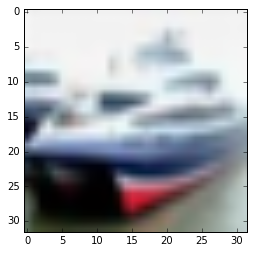

In [5]:
train_datagen = CSVGenerator(csv_location='./../adversarial/preprocessing/train_cifar10.csv',
                                 batch_size=10,
                                 nbsamples=None)

train_generator = train_datagen.batch_gen()
X_train_,Y_train_ = train_generator.__next__()

val_datagen = CSVGenerator(csv_location='./../adversarial/preprocessing/test_cifar10_keras.csv',
                                 batch_size=10,
                                 nbsamples=None)

val_generator = val_datagen.batch_gen()
X_test_,Y_test_ = val_generator.__next__()


print('Raw loading')
print('type:', X_train_.dtype)
print('Sample')

print(X_train_[1])
plt.imshow(X_test_[1])

print('X_train shape:', X_train_.shape)
print(X_train_.shape[0], 'train samples')
print(X_test_.shape[0], 'test samples')


print('Y_train shape:', Y_train_.shape)
print('Y_test shape:', Y_test_.shape)

In [7]:
print(X_test_[1][31][31][2])
print(X_test[1][31][31][2])

0.803922
0.780392


In [8]:
# load json and create model
json_file = open('models/model_gpu4.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("models/model_gpu4.h5")
print("Loaded model from disk")

'''check if weights from one network can be loaded to another acrhiture with droputs turned off'''

NameError: name 'model_from_json' is not defined

Raw loading
type: float32
Sample
[[[ 0.92256862  0.92056865  0.92056865]
  [ 0.90688235  0.90488237  0.90488237]
  [ 0.91080391  0.90880394  0.90880394]
  ..., 
  [ 0.91472548  0.91472548  0.91472548]
  [ 0.91472548  0.91272551  0.91272551]
  [ 0.90880394  0.90880394  0.90880394]]

 [[ 0.93433332  0.93433332  0.93233335]
  [ 0.92056865  0.92056865  0.92056865]
  [ 0.92256862  0.92056865  0.92056865]
  ..., 
  [ 0.92649019  0.92649019  0.92649019]
  [ 0.92649019  0.92449021  0.92449021]
  [ 0.92056865  0.92056865  0.92056865]]

 [[ 0.93041176  0.93041176  0.92841178]
  [ 0.91664708  0.91664708  0.91664708]
  [ 0.91864705  0.91664708  0.91664708]
  ..., 
  [ 0.92256862  0.92256862  0.92256862]
  [ 0.92256862  0.92256862  0.92056865]
  [ 0.91864705  0.91864705  0.91664708]]

 ..., 
 [[ 0.34217647  0.38723531  0.34801963]
  [ 0.16962746  0.199       0.14409804]
  [ 0.07550981  0.09119608  0.04413725]
  ..., 
  [ 0.66374511  0.72056866  0.70096081]
  [ 0.71272552  0.77154905  0.75586277]
  

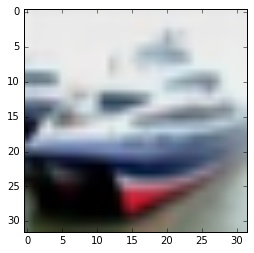

In [19]:
''' The one that works'''
adv = np.load('/u/ambrish/nparrays/adv0.001/adv_img.npy')
orig = np.load('/u/ambrish/nparrays/test/img.npy')
label = np.load('/u/ambrish/nparrays/adv0.001/label.npy')
print('Raw loading')
print('type:', adv.dtype)
print('Sample')

print(adv[1])
plt.imshow(adv[1])


print('adv shape:', adv.shape)
print('label shape:', label.shape)


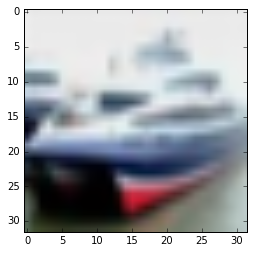

In [20]:
plt.imshow(orig[1])

In [21]:
label[2]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [162]:
m1 = np.load('/u/ambrish/models/keras_eg_alldrop/mc_acc_e.npy')
m2 = np.load('/u/ambrish/models/keras_eg_alldrop/std_acc_e.npy')
e = np.load('/u/ambrish/models/keras_eg_alldrop/e.npy')

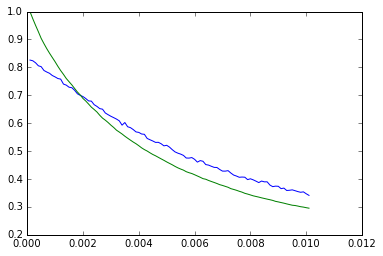

In [164]:
plt.plot(e,m1)
plt.hold(True)
plt.plot(e,m2)

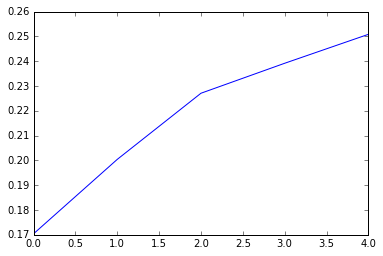

In [254]:
m = np.load('/u/ambrish/models/keras_eg_alldrop/var_ratio_e1.npy')
plt.plot(m)

In [257]:
m = np.load('/u/ambrish/models/keras_eg_alldrop/save_adv.npy')
print(m.shape)
m = m[0:100,10,:,:,:]


(101, 10000, 32, 32, 3)


(160, 64, 3)


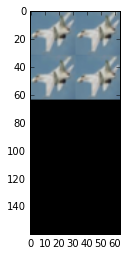

In [258]:
img_ = m
n_r = 5
n_c = 2
grid = np.zeros((n_r*32,n_c*32,3))
print(grid.shape)
for i in range(n_r*n_c):
    r = i//n_r
    c = i%n_c
    r_p = np.array([x for x in range(r*32,(r+1)*32)])
    c_p = np.array([y for y in range(c*32,(c+1)*32)])
    for x,ix in zip(r_p,np.arange(32)):
        for y,iy in zip(c_p,np.arange(32)):
            grid[x,y,:] = img_[i,ix,iy,:]
            

plt.imshow(grid)

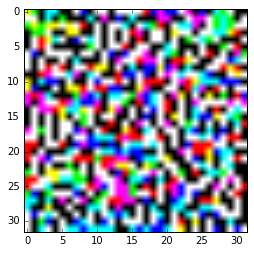

In [172]:
plt.imshow((m[99]-m[0]))

In [73]:
m_ = m.reshape((32*n_r,32*n_c,3))

In [2]:
m = np.load('/u/ambrish/models/keras_eg_alldrop/adv_old.npy')
m = m[0:100,12,:,:,:]
n_r = 10
n_c = 10
m_ = np.concatenate(m,axis=0)
m_0 = np.concatenate([np.concatenate([m[0] for i in range(n_c)],axis=1) for j in range(n_r)], axis = 0)


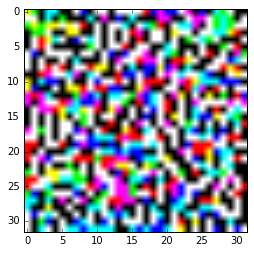

In [3]:
plt.imshow(m[99]-m[0])

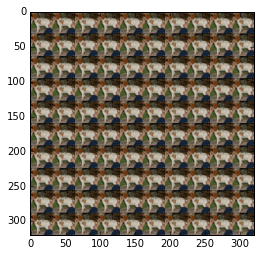

In [4]:
m = np.load('/u/ambrish/models/keras_eg_alldrop/adv_old.npy')
m = m[0:100,12,:,:,:]
n_r = 10
n_c = 10
m_ = np.concatenate(m,axis=0)
m_ = np.concatenate([m_[j*n_r*32:(j+1)*n_r*32,:,:] for j in range(n_c)], axis = 1)
plt.imshow(m_)

In [ ]:
m_0 = np.concatenate([np.concatenate([m[0] for i in range(n_c)],axis=1) for j in range(n_r)], axis = 0)
plt.imshow(1.0*(m_-m_0))

In [246]:
stoch_preds = np.load('/u/ambrish/models/keras_eg_alldrop/stoch_preds_e.npy')
stoch_preds = stoch_preds[0]
stoch_preds.shape

(200, 120, 10)

In [247]:
def var_ratio(x):
    print(x[1]==x[8])
    x_counts = np.zeros(10)
    for j in range(x.shape[0]):
        #print(np.argmax(x[j,:]),x[j,3])
        x_counts[np.argmax(x[j,:])]+=1
    return max(x_counts)

In [248]:
var_r = [var_ratio(stoch_preds[:,i,:]) for i in range(2)]

[False False False False False False False False False False]
[False False False False False False False False False False]
